In [1]:
import mmml
import matplotlib.pyplot as plt
import patchworklib as pw
import os
from pathlib import Path
import numpy as np
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [2]:
from mmml import dcmnet

In [3]:
import jax

from mmml.dcmnet.dcmnet.data import prepare_datasets
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model, train_model_dipo

key = jax.random.PRNGKey(0)


In [4]:
NDCM = 4
model = MessagePassingModel(
    features=128, max_degree=2, num_iterations=3,
    num_basis_functions=64, cutoff=8.0, n_dcm=NDCM,
    include_pseudotensors=False,
)

## Data

In [6]:
index = 30
data_path_resolved = Path('/home/ericb/testmmml/test.npz') #data_files[index].resolve()
data_loaded = np.load(data_path_resolved, 
allow_pickle=True)
data_path_resolved

PosixPath('/home/ericb/testmmml/test.npz')

In [7]:
# factorize a number
def factorize(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

factorize(data_loaded["esp"].shape[1])

[1, 2, 5, 10, 4451, 8902, 22255, 44510]

R
(1983, 18, 3)
D
(1983, 3)


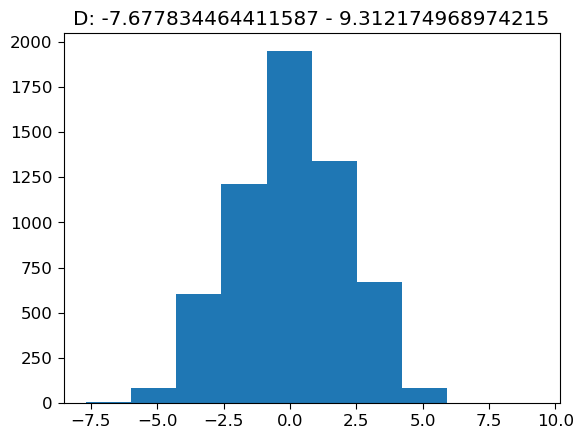

Q
(1983, 3, 3)
Z
(1983, 18)


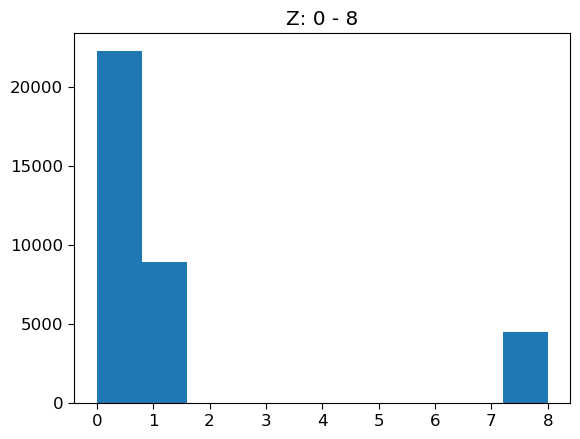

esp
(1983, 44510)


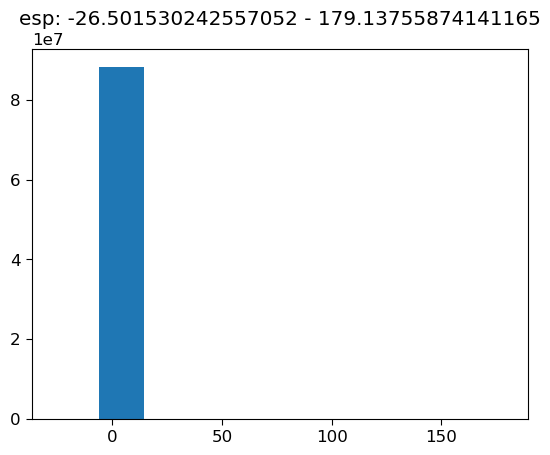

esp_grid
(1983, 44510, 3)
F
(1983, 18, 3)


In [9]:
for k in data_loaded.keys():
    
    print(k)
    shape = data_loaded[k].shape
    print(shape
    )
    if len(shape) < 3:
        try:
            d = data_loaded[k]
            d = d.flatten()
            plt.hist(d)
            title = f"{k}: {d.min()} - {d.max()}"
            plt.title(title)
            plt.show()
        except:
            pass

In [10]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    clean=False,
    esp_mask=False,
    clip_esp=False,
    natoms=60,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [11]:
n_sample = 1000  # Number of points to keep
data_key = jax.random.PRNGKey(0)

train_data, valid_data = prepare_datasets(
    data_key, num_train=1000, num_valid=100,
    filename=[data_path_resolved],
    clean=False, esp_mask=False,
    natoms=18,
    clip_esp=False,
)


shape (1983, 18, 3)
D (1983, 3)
Q 3 (1983, 3, 3) 1983
Q (1983, 3, 3)
R (1983, 18, 3)
(1983, 18, 3)
['R', 'Z', 'F', 'esp', 'D', 'esp_grid', 'Q']
1983
0 R 1983 (1983, 18, 3)
1 Z 1983 (1983, 18)
2 F 1983 (1983, 18, 3)
3 esp 1983 (1983, 44510)
4 D 5949 (5949, 1)
5 esp_grid 1983 (1983, 44510, 3)
6 Q 1983 (1983, 3, 3)


In [1]:

def random_sample_esp(esp, esp_grid, n_sample, seed=42):
    np.random.seed(seed)
    sampled_esp = []
    sampled_grid = []
    
    for i in range(len(esp)):
        lessthan = esp[i] < 2
        morethan = esp[i] > -2
        not_0 = esp[i] != 0.0
        condmask = lessthan*morethan*not_0
        _shape = esp[i][condmask].shape[0]
        print(_shape)
        indices = np.random.choice(_shape, n_sample, replace=False)
        indices = np.sort(indices) 
        sampled_esp.append(esp[i][condmask][indices])
        sampled_grid.append(esp_grid[i][condmask][indices])
    
    return np.array(sampled_esp), np.array(sampled_grid)

train_data["esp"], train_data["esp_grid"] = random_sample_esp(
    train_data["esp"] , train_data["esp_grid"], n_sample
)
valid_data["esp"], valid_data["esp_grid"] = random_sample_esp(
    valid_data["esp"] , valid_data["esp_grid"], n_sample
)


valid_data["esp"] = 0.0016 * 0 + valid_data["esp"]
train_data["esp"] = 0.0016 * 0 + train_data["esp"]

train_data["vdw_surface"] = train_data["esp_grid"] 
valid_data["vdw_surface"] = valid_data["esp_grid"] 
train_data["n_grid"] = np.full(len(train_data["vdw_surface"]), n_sample)
valid_data["n_grid"] = np.full(len(valid_data["vdw_surface"]), n_sample)


train_data["vdw_surface"] = train_data["esp_grid"]
valid_data["vdw_surface"] = valid_data["esp_grid"]

Hs_train = train_data["Z"] == 1.0
Os_train = train_data["Z"] == 8.0
Hs_valid = valid_data["Z"] == 1.0
Os_valid = valid_data["Z"] == 8.0

# train_data["mono"] = np.zeros_like(train_data["Z"])
# valid_data["mono"] = np.zeros_like(valid_data["Z"])

train_data["mono"] = Hs_train * 0.1 + Os_train * -0.2
valid_data["mono"] = Hs_valid * 0.1 + Os_valid * -0.2

# Fix n_grid shape
train_data["n_grid"] = np.full(train_data["Z"].shape[0], n_sample)
valid_data["n_grid"] = np.full(valid_data["Z"].shape[0], n_sample)

# Fix N shape  
train_data["N"] = np.count_nonzero(train_data["Z"], axis=1)
valid_data["N"] = np.count_nonzero(valid_data["Z"], axis=1)

NameError: name 'train_data' is not defined

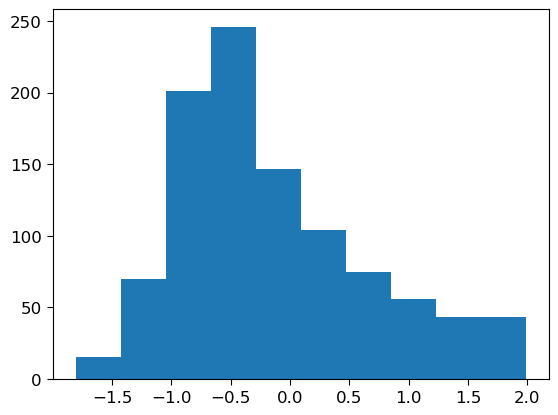

In [13]:
_ = plt.hist(valid_data["esp"][1])

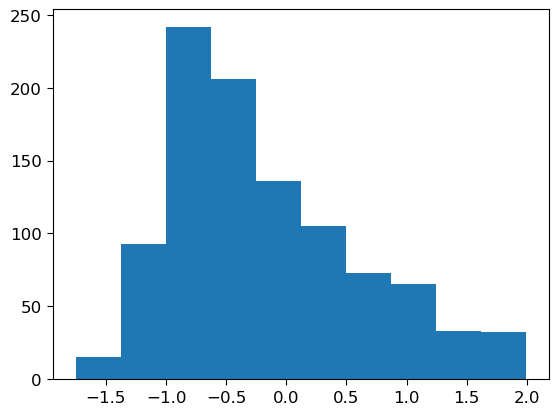

In [14]:
_ = plt.hist(valid_data["esp"][0])

In [15]:
# valid_data["esp"][0][lessthan * morethan ].shape

In [16]:
# Check current batch shapes
print("After fixes:")
batch = {k: v[0:1] if len(v.shape) > 0 else v for k, v in train_data.items()}
for key in ['mono', 'esp', 'vdw_surface', 'n_grid', 'N', 'R', 'Z']:
    if key in batch:
        print(f"{key}: {batch[key].shape}")

# Also check the specific values
print(f"\nmono values: {batch['mono']}")
print(f"N values: {batch['N']}")
print(f"n_grid values: {batch['n_grid']}")

After fixes:
mono: (1, 18)
esp: (1, 1000)
vdw_surface: (1, 1000, 3)
n_grid: (1,)
N: (1,)
R: (1, 18, 3)
Z: (1, 18)

mono values: [[-0.2  0.1  0.1 -0.2  0.1  0.1  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. ]]
N values: [6]
n_grid values: [1000]


In [17]:
esp_data = train_data["esp"]
esp_data.shape

(1000, 1000)

## Training (1)

In [18]:
train_model?

Signature:     
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    chg_w=0.01,
    restart_params=None,
    *,
    loss_step_fn: Callable = <PjitFunction of <function train_step at 0x722890a23100>>,
    eval_step_fn: Callable = <PjitFunction of <function eval_step at 0x7228907ee660>>,
    optimizer_fn: Callable = <function <lambda> at 0x7228907ef1a0>,
    use_ema: bool = True,
    ema_decay: float = 0.999,
    use_grad_clip: bool = True,
    grad_clip_norm: float = 2.0,
    log_extra_metrics: Optional[Callable] = <function _log_extra_metrics_none at 0x7228907ef060>,
    save_best_params_with_ema: bool = True,
    extra_valid_args: dict = None,
    extra_train_args: dict = {'chg_w': 0.01},
)
Call signature: train_model(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function train_model_general at 0x7228907eefc0>, loss_step_fn=<PjitFunction of <...> etric

In [ ]:
params, valid_loss = train_model(
    key=data_key, model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=10, learning_rate=1e-4, batch_size=1,
    # restart_params=params if params is None else params,
    ndcm=model.n_dcm, esp_w=1.0, chg_w=0.0, use_grad_clip=True, grad_clip_norm=1.0,
)
new_params = params.copy()

Preparing batches
..................


In [ ]:
import pandas as pd
params = pd.read_pickle("best_1.0_params.pkl")

In [ ]:
params['params'].keys()



In [ ]:
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis, prepare_batch

?dcmnet_analysis
?prepare_batch
prepare_batches?

In [ ]:
prepare_batch_for_analysis?

In [ ]:
batch["D"]

In [ ]:
from mmml.dcmnet.dcmnet.data import prepare_batches
from mmml.dcmnet.dcmnet.analysis import dcmnet_analysis

def prepare_batch_for_analysis(data, index=0):
    """Prepare a single batch correctly for dcmnet_analysis."""
    # Extract single item but keep batch dimension
    _dict = {k: np.array(v[[index]]) for k, v in data.items()}
    
    # Use prepare_batches with include_id=True
    batch = prepare_batches(jax.random.PRNGKey(0), _dict, batch_size=1, include_id=False, num_atoms =18)[0]
    batch["com"] = np.array([0,0,0])
    batch["Dxyz"] = np.array([0,0,0])
    return batch

batch = prepare_batch_for_analysis(train_data, index=0)
output = dcmnet_analysis(params, model, batch, 18)
print(f"RMSE: {output['rmse_model']:.6f}")
print(f"RMSE (masked): {output['rmse_model_masked']:.6f}")

In [ ]:
from mmml.dcmnet.dcmnet.utils import apply_model
NATOMS = 18
_ = apply_model(model, params, batch, 1, NATOMS)

In [ ]:
batch["R"][:6]

In [ ]:
6*4

In [ ]:
m,d = _
# d.reshape(1, 18 * 4, 3)[0,:6*model.n_dcm]
d[:6*model.n_dcm]

In [ ]:
dcmnet_analysis

In [ ]:
batch

In [47]:
import ase
from ase.visualize import view
atoms = ase.Atoms(batch["Z"][:int(batch["N"])], 
batch["R"][:int(batch["N"])])
view(atoms, viewer="x3d")


In [48]:
output.keys()
output["mono"].sum(axis=-1)

Array([[-0.03346378,  0.01589256,  0.01703138, -0.03285515,  0.01785599,
         0.01553901, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        ]], dtype=float32)

In [49]:
output["dipo"][:24]

Array([[-0.6064283 , -0.60638535, -0.6064326 ],
       [-0.60628474, -2.253015  , -2.253218  ],
       [-2.2531066 , -2.2530694 , -0.96354294],
       [-0.96342117, -0.96361274, -0.96359384],
       [-0.10809042, -0.1081104 , -0.10845715],
       [-0.10819157, -1.5776685 , -1.5774219 ],
       [-1.5775952 , -1.5781533 , -1.4450614 ],
       [-1.4451215 , -1.4448004 , -1.4449512 ],
       [-0.0801274 , -0.08015022, -0.08028446],
       [-0.08005732, -3.0487196 , -3.0483193 ],
       [-3.0487175 , -3.048779  , -1.0151576 ],
       [-1.01506   , -1.0150647 , -1.0152061 ],
       [ 0.46993098,  0.46992043,  0.4699318 ],
       [ 0.46993214,  1.2645212 ,  1.2645427 ],
       [ 1.2645549 ,  1.2645202 ,  2.799169  ],
       [ 2.7991672 ,  2.7992885 ,  2.7992744 ],
       [-0.18725027, -0.18727703, -0.18722615],
       [-0.18738152,  0.6779974 ,  0.6779091 ],
       [ 0.67803735,  0.6782198 ,  2.3948095 ],
       [ 2.394771  ,  2.3943624 ,  2.394814  ],
       [ 0.03126052,  0.03127636,  0.031

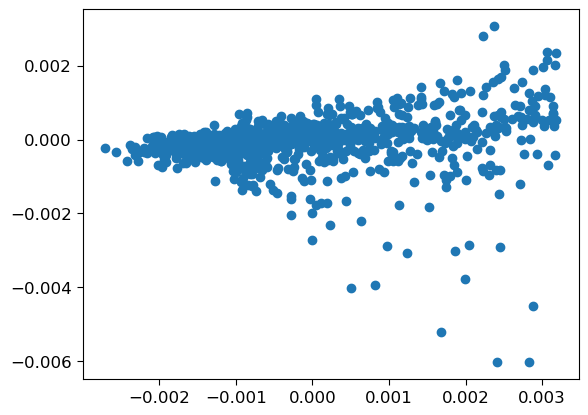

In [50]:
plt.scatter(batch["esp"], output['esp_pred'])

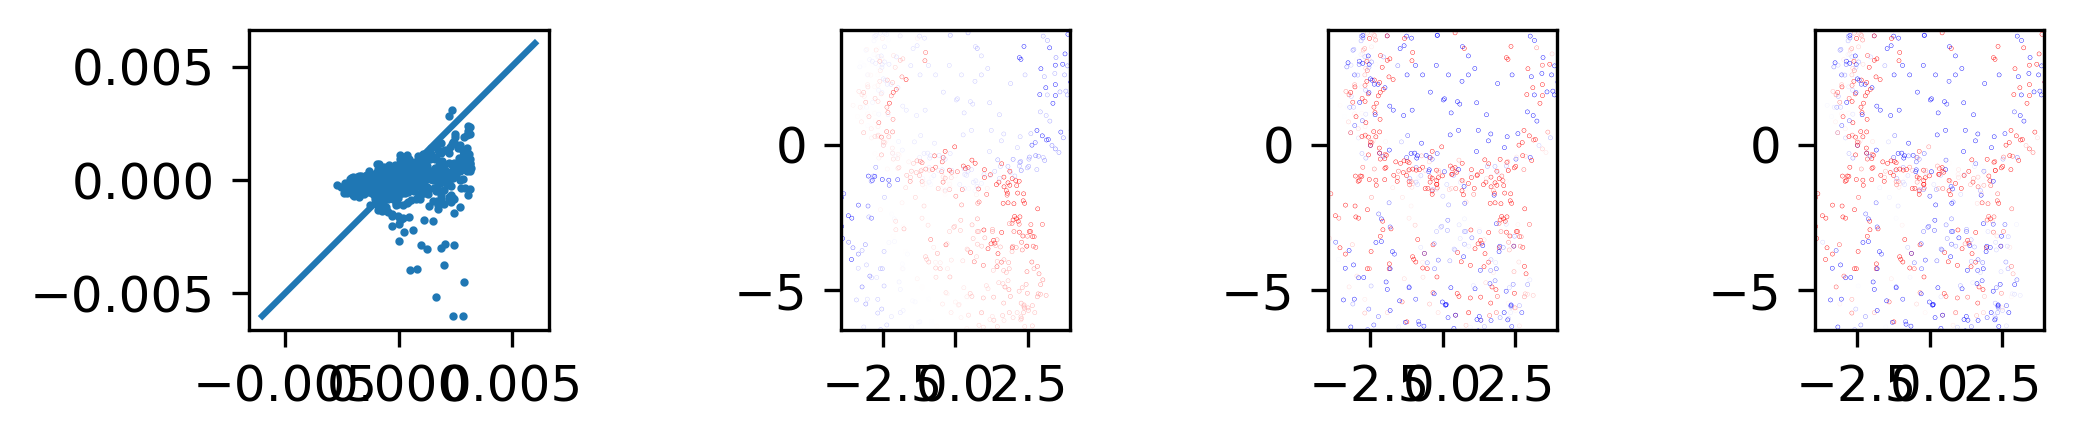

In [51]:
import patchworklib as pw
VMAX = 0.001
xy_ax = pw.Brick()
xy_ax.scatter(batch["esp"], output['esp_pred'], s=1)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
xy_ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
xy_ax.set_aspect('equal')

ax_true = pw.Brick()
Npoints = 1000
vdw_surface_min = np.min(batch["vdw_surface"][0], axis=-1)
vdw_surface_max = np.max(batch["vdw_surface"][0], axis=-1)

ax_true.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_true.set_aspect('equal')

ax_pred = pw.Brick()

ax_pred.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
max_val = np.sqrt(max(np.max(batch["esp"]**2), np.max(output['esp_pred']**2)))
# ax.plot(np.linspace(-max_val, max_val, 100), np.linspace(-max_val, max_val, 100))
ax_pred.set_aspect('equal')


ax_diff = pw.Brick()
ax_diff.scatter(
    batch["vdw_surface"][0][:Npoints,0], 
batch["vdw_surface"][0][:Npoints,1], 
c=batch["esp"][0][:Npoints] - output['esp_pred'][:Npoints],
s=0.01,
    vmin=-VMAX, vmax=VMAX
)
ax_diff.set_aspect('equal')

for _ in [ax_pred, ax_true, ax_diff]:
    _.set_xlim(vdw_surface_min[0], -vdw_surface_min[0])
    _.set_ylim(vdw_surface_min[1], -vdw_surface_min[0])


xy_ax | ax_pred | ax_true | ax_diff



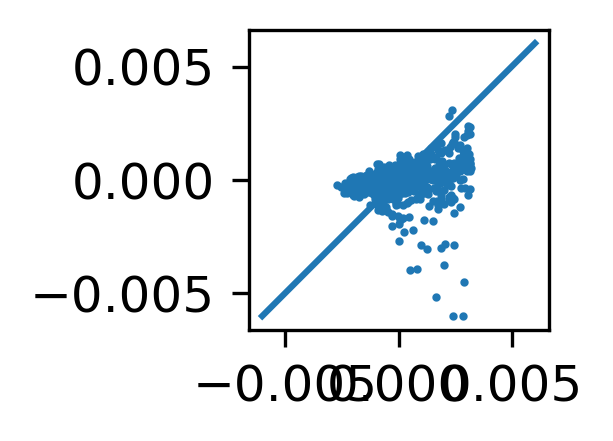

In [52]:
xy_ax

In [55]:
output["mono"][0][:int(batch["N"])].sum(axis=-1)


Array([-0.03346378,  0.01589256,  0.01703138, -0.03285515,  0.01785599,
        0.01553901], dtype=float32)

In [56]:
output["mono"][0][:int(batch["N"])*model.n_dcm]

Array([[-0.01257535, -0.00826692, -0.00398547, -0.00863604],
       [-0.00354714,  0.00113241,  0.01039935,  0.00790794],
       [-0.00020418,  0.00191874,  0.00860545,  0.00671137],
       [-0.01181264, -0.00872583, -0.00476043, -0.00755625],
       [-0.00122698,  0.00167238,  0.00948847,  0.00792211],
       [-0.00121939,  0.00161734,  0.00867564,  0.00646541],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.        , -0.

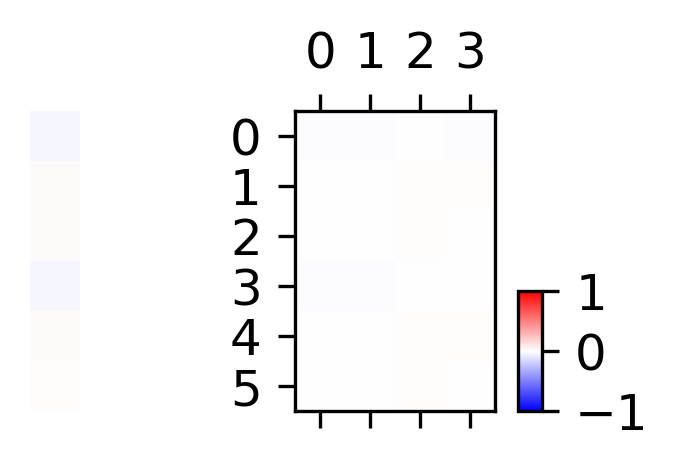

In [57]:
charge_ax = pw.Brick()
charge_ax.matshow(output["mono"][0][:int(batch["N"])],vmin=-1,vmax=1)
scharge_ax = pw.Brick()
scharge_ax.matshow(output["mono"][0][:int(batch["N"])].sum(axis=-1)[:, None],vmin=-1,vmax=1)
# scharge_ax.add_colorbar(vmin=-1,vmax=1)
scharge_ax.axis("off")
f = (scharge_ax | charge_ax)
f.add_colorbar(vmin=-1,vmax=1)

In [58]:
R = output["dipo"][:int(batch["N"])*NDCM]
Z = np.array([1 if _ > 0 else 1 for _ in output["mono"][0][:int(batch["N"])].flatten()])
R.shape, Z.shape
dcm_atoms = ase.Atoms(Z, R)
view(dcm_atoms,  viewer="x3d")

In [ ]:
new_params, valid_loss = train_model(
    key=jax.random.PRNGKey(0), model=model,
    writer=None,
    train_data=train_data, valid_data=valid_data,
    num_epochs=100, learning_rate=5e-4, batch_size=1,
    ndcm=model.n_dcm, esp_w=1000.0,
    restart_params=params if new_params is None else new_params,
)

In [ ]:
key